# **Import relevant libraries**

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Multilayer Perceptron**

In [ ]:
# Define Multilayer Perceptron
class MultiLayerNet(torch.nn.Module):
    def __init__(self, input_size, frst_hidden_neurons, scnd_hidden_neurons, output_size):
        super(MultiLayerNet, self).__init__()
        # Define the hidden layer with input_size input features and hidden_neurons neurons
        self.first_hidden_layer = torch.nn.Linear(input_size, frst_hidden_neurons)
        self.second_hidden_layer = torch.nn.Linear(frst_hidden_neurons, scnd_hidden_neurons)

        # Define the output layer with hidden_neurons input features and output_size neurons
        self.output_layer = torch.nn.Linear(scnd_hidden_neurons, output_size)

    def forward(self, x):
        # Pass the input through the hidden layer and apply the sigmoid activation function
        frst_hidden_output = torch.relu(self.first_hidden_layer(x))
        scnd_hidden_output = torch.softmax(self.second_hidden_layer(frst_hidden_output), dim=1)

        # Pass the hidden layer output through the output layer and apply the sigmoid activation function
        y_pred = torch.sigmoid(self.output_layer(scnd_hidden_output))

        return y_pred

In [ ]:
learningRate = 0.01
epochs = 10000

model = MultiLayerNet(16, 64, 64, 1)  #input_size, hidden_neuron, output_size
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.BCELoss()   #Binary Cross Entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# GridSearch Hyperparameters Tuning

In [ ]:
# Define parameter grid for GridSearchCV
param_grid = {
    'frst_hidden_neurons': [16, 32, 64, 128],
    'scnd_hidden_neurons': [16, 32, 64, 128],
    'learningRate': [0.001, 0.01],
    'epochs': [10000]
}

In [ ]:
# Create a wrapper class for your PyTorch model to make it compatible with scikit-learn
acc_GS = [0]
training_loss_GS = []
eval_loss_GS = []

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, frst_hidden_neurons, scnd_hidden_neurons, output_size, learningRate, epochs):
        self.input_size = input_size
        self.frst_hidden_neurons = frst_hidden_neurons
        self.scnd_hidden_neurons = scnd_hidden_neurons
        self.output_size = output_size
        self.learningRate = learningRate
        self.epochs = epochs
        self.model = MultiLayerNet(input_size, frst_hidden_neurons, scnd_hidden_neurons, output_size)
        self.criterion = torch.nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learningRate)

    def fit(self, X, y):
        global acc_GS, training_loss_GS, eval_loss_GS
        training_loss = []
        eval_loss = []
        acc_list = []
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

        print(f"Parameters: frst_hidden_neurons={self.frst_hidden_neurons}, scnd_hidden_neurons={self.scnd_hidden_neurons}, learningRate={self.learningRate}, epochs={self.epochs}")

        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            self.optimizer.step()
            self.classes_ = np.unique(y)

            if epoch % 1000 == 0:
              print('epoch {}, loss {}'.format(epoch, loss.item()))

              training_loss.append(loss.item())

              for x__val_batch, y__val_batch in test_loader_sc:
                val_outputs = self.model(x__val_batch)
                val_loss = self.criterion(val_outputs, y__val_batch)

                acc = (val_outputs.round() == y__val_batch).float().mean()

              if epoch % 1000 == 0:
                print("Model accuracy: %.2f%%" % (float(acc)*100))
                print('epoch {}, val_loss {}\n'.format(epoch, val_loss.item()))

              eval_loss.append(val_loss.item())
              acc_list.append(float(acc))

        if acc_list[-1] > acc_GS[-1]:
          acc_GS = acc_list
          training_loss_GS = training_loss
          eval_loss_GS = eval_loss
        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return (outputs > 0.5).numpy().astype(int)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create an instance of your PyTorchClassifier
X_train = train_set[columns].values
y_train = train_set['Outcome'].map({'Preterm': 1, 'Healthy': 0}).to_numpy()
X_test = test_set[columns].values
y_test = test_set['Outcome'].map({'Preterm': 1, 'Healthy': 0}).to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pytorch_model = PyTorchClassifier(input_size=16, frst_hidden_neurons=30, scnd_hidden_neurons=30, output_size=1, learningRate=0.01, epochs=100)
grid_search = GridSearchCV(estimator=pytorch_model, param_grid=param_grid, scoring='accuracy', cv=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Parameters: frst_hidden_neurons=16, scnd_hidden_neurons=16, learningRate=0.001, epochs=10000
epoch 0, loss 0.6960772275924683
Model accuracy: 50.00%
epoch 0, val_loss 0.6952409148216248

epoch 1000, loss 0.2572951018810272
Model accuracy: 80.92%
epoch 1000, val_loss 0.5570586919784546

epoch 2000, loss 0.22471719980239868
Model accuracy: 82.08%
epoch 2000, val_loss 0.5759208798408508

epoch 3000, loss 0.224695086479187
Model accuracy: 82.08%
epoch 3000, val_loss 0.5743076801300049

epoch 4000, loss 0.22468730807304382
Model accuracy: 81.79%
epoch 4000, val_loss 0.5774239301681519

epoch 5000, loss 0.2246834635734558
Model accuracy: 82.08%
epoch 5000, val_loss 0.5812273025512695

epoch 6000, loss 0.22468140721321106
Model accuracy: 82.08%
epoch 6000, val_loss 0.5840731263160706

epoch 7000, loss 0.22468025982379913
Model accuracy: 81.50%
epoch 7000, val_loss 0.586154580116272

epoch 8000, loss 0.2246795892715454
Model accuracy: 81.50%
epoch 8000, val_loss 0.5883135795593262

epoch 9000,

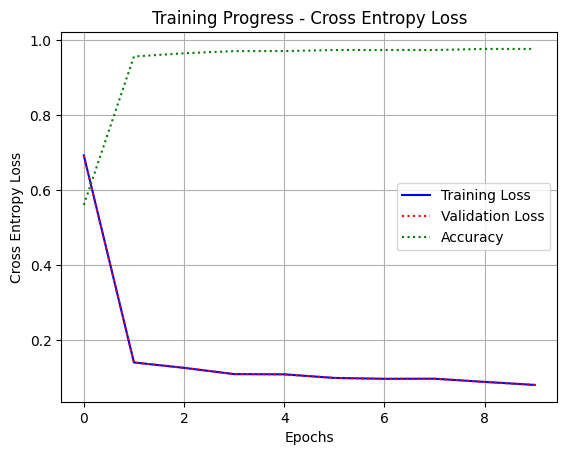

In [ ]:
# Plot the cost (loss) over epochs
plt.plot(training_loss_GS, linestyle='-', color='b', label='Training Loss')
plt.plot(eval_loss_GS, linestyle=':', color='r', label='Validation Loss')
plt.plot(acc_GS, linestyle=':', color='g', label='Accuracy')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Progress - Cross Entropy Loss')

# Add grid for better readability
plt.grid(True)

# Show legend
plt.legend()
plt.savefig('train_GS.jpg')
# Display the plot
plt.show()

# Random Search Parameter Tuning

In [ ]:
from scipy.stats import randint, uniform

# Define the hyperparameter search space
space = {
    'epochs': randint(1000, 10000),
    'frst_hidden_neurons': randint(16, 128),
    'scnd_hidden_neurons': randint(16, 128),
    'learningRate': uniform(0.001, 0.1)
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

X_train = train_set[columns].values
y_train = train_set['Outcome'].map({'Preterm': 1, 'Healthy': 0}).to_numpy()
X_test = test_set[columns].values
y_test = test_set['Outcome'].map({'Preterm': 1, 'Healthy': 0}).to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pytorch_model = PyTorchClassifier(input_size=16, frst_hidden_neurons=30, scnd_hidden_neurons=30, output_size=1, learningRate=0.01, epochs=100)
random_search = RandomizedSearchCV(pytorch_model, space, scoring='accuracy', cv=2)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Parameters: frst_hidden_neurons=115, scnd_hidden_neurons=67, learningRate=0.003946223597866094, epochs=2114
epoch 0, loss 0.6934359073638916
Model accuracy: 50.00%
epoch 0, val_loss 0.6929336190223694

epoch 1000, loss 0.1298789083957672
Model accuracy: 83.53%
epoch 1000, val_loss 0.6059988141059875

epoch 2000, loss 0.12918423116207123
Model accuracy: 83.82%
epoch 2000, val_loss 0.6149184107780457

Parameters: frst_hidden_neurons=115, scnd_hidden_neurons=67, learningRate=0.003946223597866094, epochs=2114
epoch 0, loss 0.6958162784576416
Model accuracy: 50.00%
epoch 0, val_loss 0.6948179006576538

epoch 1000, loss 0.07912030071020126
Model accuracy: 83.82%
epoch 1000, val_loss 0.6156836748123169

epoch 2000, loss 0.07572256773710251
Model accuracy: 83.53%
epoch 2000, val_loss 0.6937779784202576

Parameters: frst_hidden_neurons=75, scnd_hidden_neurons=102, learningRate=0.003165252158731923, epochs=2026
epoch 0, loss 0.693733811378479
Model accuracy: 50.00%
epoch 0, val_loss 0.6930990219

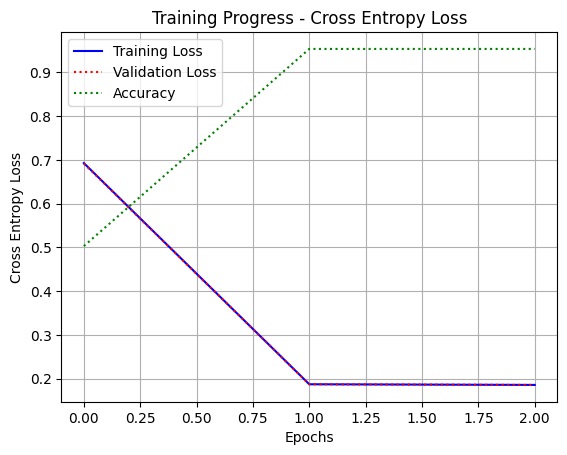

In [ ]:
# Plot the cost (loss) over epochs
plt.plot(training_loss_RS, linestyle='-', color='b', label='Training Loss')
plt.plot(eval_loss_RS, linestyle=':', color='r', label='Validation Loss')
plt.plot(acc_RS, linestyle=':', color='g', label='Accuracy')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Progress - Cross Entropy Loss')

# Add grid for better readability
plt.grid(True)

# Show legend
plt.legend()
plt.savefig('train_rs.jpg')
# Display the plot
plt.show()